# Problem Statement (Melanoma Detection)



>To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

>The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

>The data set contains the following diseases:

>- Actinic keratosis
>- Basal cell carcinoma
>- Dermatofibroma
>- Melanoma
>- Nevus
>- Pigmented benign keratosis
>- Seborrheic keratosis
>- Squamous cell carcinoma
>- Vascular lesion

**Tensorflow, keras and Augmentor to be in installed first if not available in Environment by using below mentioned commands.**

!pip install tensorflow

!pip install keras

!pip install Augmentor

In [8]:
pip install tensorflow

In [9]:
!pip install keras

In [10]:
!pip install Augmentor

**Importing required Libraries**

### Importing Dataset

In [13]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Rescaling, InputLayer

**To import data from Google Drive**

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# Checking versions of Libraries
f'NumPy version: {np.__version__} | Pandas version: {pd.__version__} | keras version: {keras.__version__} | tf version: {tf.__version__}'

'NumPy version: 1.26.4 | Pandas version: 2.1.4 | keras version: 3.4.1 | tf version: 2.17.0'

In [15]:
# Importing from local machine
data_dir_train = pathlib.Path("/content/drive/MyDrive/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Test')

In [16]:
# to count total no of images in dataset
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2268
118


**Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

**Defining dataset**

Define some batch size, height and width of image to load

In [17]:
batch_size = 32
img_height = 180
img_width = 180

**Image loading by using keras.preprocessing**

Image to be loaded off from dataset by image_dataset_from_directory utility.

Splitting 80% of the data for training the model and 20% for validation segment.

In [18]:
# segmenting train and validation set from dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  label_mode="int",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2268 files belonging to 9 classes.
Using 1815 files for training.


In [19]:
# Segregation of validation set from dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  label_mode="int",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2268 files belonging to 9 classes.
Using 453 files for validation.


In [20]:
# Classifying all type of skin cancer
Name_of_class = train_dataset.class_names
print(Name_of_class)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [21]:
# Coutning no's of images in each class type of Train datset
for i in Name_of_class:
  print(i,": ",len(list(data_dir_train.glob('{}/*.jpg'.format(i)))))

actinic keratosis :  123
basal cell carcinoma :  376
dermatofibroma :  95
melanoma :  448
nevus :  367
pigmented benign keratosis :  462
seborrheic keratosis :  77
squamous cell carcinoma :  181
vascular lesion :  139


In [22]:
# Coutning no's of images in each class type of Test datset
for i in Name_of_class:
  print(i,": ",len(list(data_dir_test.glob('{}/*.jpg'.format(i)))))

actinic keratosis :  16
basal cell carcinoma :  16
dermatofibroma :  16
melanoma :  16
nevus :  16
pigmented benign keratosis :  16
seborrheic keratosis :  3
squamous cell carcinoma :  16
vascular lesion :  3


### Data Visulisation   

Having random view of each type of Images

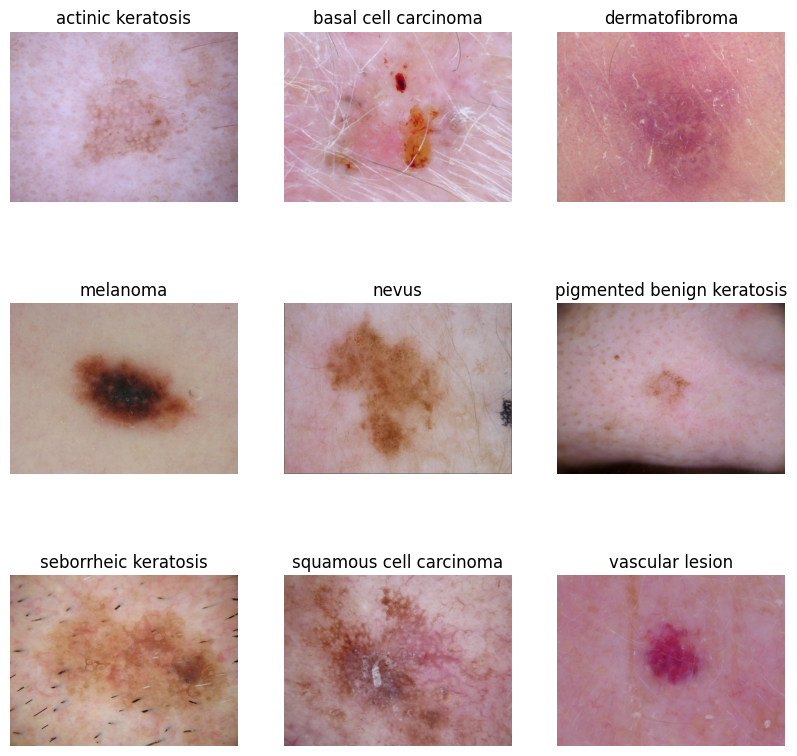

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for index,images in enumerate(Name_of_class):

  temp=plt.imread(list(data_dir_train.glob('{}/*.jpg'.format(images)))[0])

  plt.subplot(3,3,index+1)
  plt.imshow(temp)
  plt.axis('off')
  plt.title(images)


In [24]:
# to confirm shape and size of Image
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


A tensor of the size (32, 180, 180, 3) is dimension of one image batch. Here it is group of 32 images with dimension 180x180x3 (the last one is for color channels RGB).

In [25]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset= validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

#Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

#Dataset.prefetch() overlaps data preprocessing and model execution while training.

**Standardization of images**

The RGB channel values ranges in between 0 to 225, which is not good in case of neural network. Ideally it should be in between 0 and 1.

In [28]:
normalised_layer = tf.keras.layers.Rescaling(1./255)
normalized_dataset = train_dataset.map(lambda x, y: (normalised_layer(x), y))
image_batch, labels_batch = next(iter(normalized_dataset))

### Model 1

Creating First model to identify total 9 classes in dataset.

In [29]:
# Define image dimensions
img_height = 180
img_width = 180

# Initialize the model
model = Sequential([
    Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # Corrected input_shape here
    Conv2D(16, 3, activation='relu', padding='same'),
    MaxPooling2D(),
    Conv2D(32, 3, activation='relu', padding='same'),
    MaxPooling2D(),
    Conv2D(64, 3, activation='relu', padding='same'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(9, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Compilation of Model**

Using adam as optimiser and loss function to train the Model

In [30]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [31]:
# Checking summery of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Model after optimising with 20 epochs

In [32]:
epochs = 20
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 218s 4s/step - accuracy: 0.1937 - loss: 2.1990 - val_accuracy: 0.3267 - val_loss: 1.8295
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 46s 19ms/step - accuracy: 0.3476 - loss: 1.7899 - val_accuracy: 0.4570 - val_loss: 1.5352
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4555 - loss: 1.6009 - val_accuracy: 0.5298 - val_loss: 1.3866
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5362 - loss: 1.3828 - val_accuracy: 0.4547 - val_loss: 1.4814
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5226 - loss: 1.3711 - val_accuracy: 0.5276 - val_loss: 1.3666
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5715 - loss: 1.2596 - val_accuracy: 0.5497 - val_loss: 1.2840
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5803 - loss: 1.2079 - val_accuracy: 0.5497 - val_loss: 1.3480
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5930 - loss: 1.1690 - val_accuracy: 0.5938 - 

### Checking results of Model 1

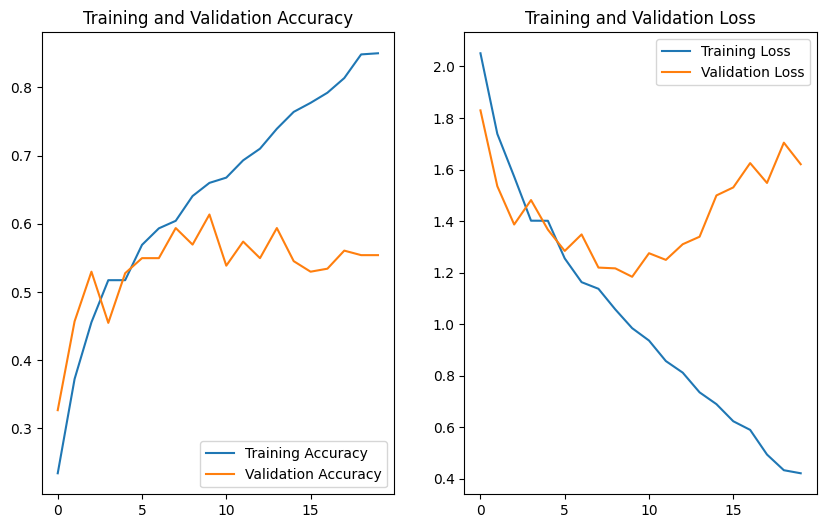

In [33]:
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings:**

Train Data Accuracy : 0.9224

Train Loss : 0.1801

Validation Data Accuracy : 0.5391

Validation Loss - 2.6361

**Nutshell:**

Accuracy figures indicates that model is highly overfit, secondly loss value of validation dataset is higher.

**Correction:**
Model need augmentation also dropout in layers.

### Data Augmentation

Augmentation is kind of apply flip, rotate, zoom for data input while model building, to enhance result.

In [35]:
# data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
#                              layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
#                              layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')])

# Data augmentation pipeline
data_augmentation = Sequential([
    layers.RandomFlip(mode="horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.2, fill_mode='reflect'),
    layers.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

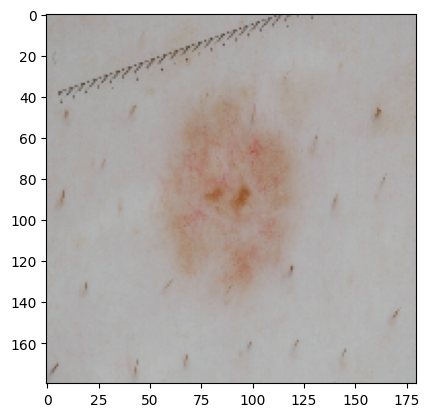

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_augmentation1=ImageDataGenerator(rescale=1./255,
                   horizontal_flip=True,
                   zoom_range=0.2)
image_batch,label_batch=next(iter(train_dataset))
temp=image_batch[0].numpy()
plt.imshow(temp.astype('uint8'))

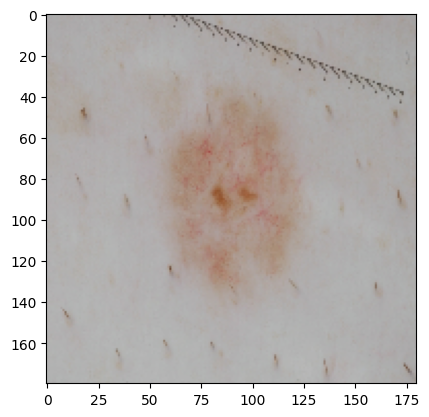

In [37]:
#Checking effect of augmentation on one of image
plt.imshow(data_augmentation1.apply_transform(temp,transform_parameters={'flip_horizontal':True}).astype('uint8'))

### Building Model 2 after Augmentation

In [39]:
Augmented_data_model=Sequential([data_augmentation,
                    layers.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
Augmented_data_model.add(Conv2D(16, 3, activation='relu',padding='same',input_shape = (180, 180, 32)))
Augmented_data_model.add(MaxPooling2D())

Augmented_data_model.add(Conv2D(32, 3, activation='relu',padding='same'))
Augmented_data_model.add(MaxPooling2D())
Augmented_data_model.add(Conv2D(64, 3, activation='relu',padding='same'))
Augmented_data_model.add(MaxPooling2D())
Augmented_data_model.add(Dropout(0.25))

Augmented_data_model.add(Flatten())
Augmented_data_model.add(Dense(128, activation='relu'))
Augmented_data_model.add(Dense(9, activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
#Compiling the model built after data augmentation
Augmented_data_model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [41]:
# Checking summary of Model built by augmenting data
Augmented_data_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_4 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [42]:
# Training model after data augmentation with 20 epoches
epochs = 20
history = Augmented_data_model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.1675 - loss: 2.2330 - val_accuracy: 0.3068 - val_loss: 1.9960
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.2755 - loss: 1.9591 - val_accuracy: 0.3223 - val_loss: 1.8179
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.3574 - loss: 1.7549 - val_accuracy: 0.3554 - val_loss: 1.7603
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4067 - loss: 1.6876 - val_accuracy: 0.4371 - val_loss: 1.6140
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4468 - loss: 1.5599 - val_accuracy: 0.4812 - val_loss: 1.4535
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4446 - loss: 1.5304 - val_accuracy: 0.5188 - val_loss: 1.4316
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4888 - loss: 1.4742 - val_accuracy: 0.5386 - val_loss: 1.3457
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4914 - loss: 1.4634 - val_accuracy: 0.5143 - v

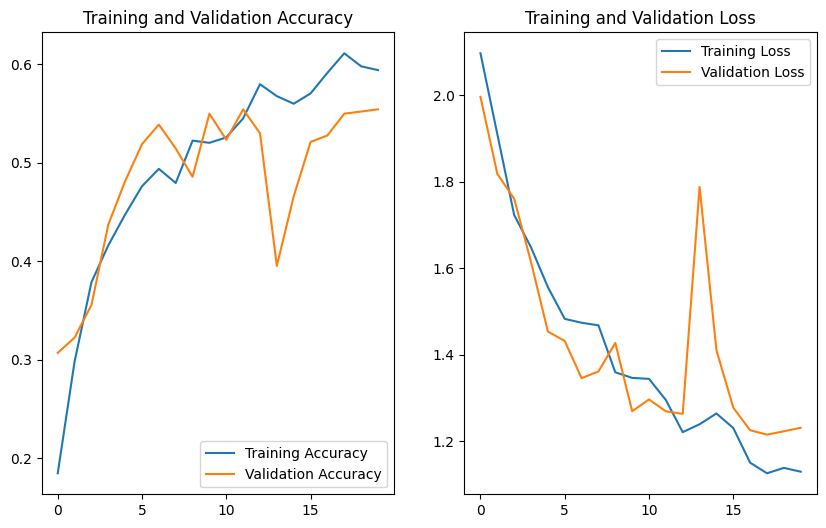

In [43]:
# Visualizing the result
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings:**

Train Data Accuracy : 0.5965

Train Loss : 1.1124

Validation Data Accuracy : 0.5369

Validation Loss - 1.3549

**Nutshell:**

Accuracy figures indicates that model is highly underfit.

**Correction:**
Data imbalancing to be checked.

### Class Imbalance checking

Numerous datasets can have class awkwardness, one class can have proportionately larger number of tests contrasted with the others. Class irregularity can unfavorably affect the last model quality. Consequently as a second look just in case it becomes essential to actually look at what is the dispersion of classes in the information.

In [44]:
for i in Name_of_class:
  print(i,": ",len(list(data_dir_train.glob('{}/*.jpg'.format(i)))))

actinic keratosis :  123
basal cell carcinoma :  376
dermatofibroma :  95
melanoma :  448
nevus :  367
pigmented benign keratosis :  462
seborrheic keratosis :  77
squamous cell carcinoma :  181
vascular lesion :  139


<BarContainer object of 9 artists>

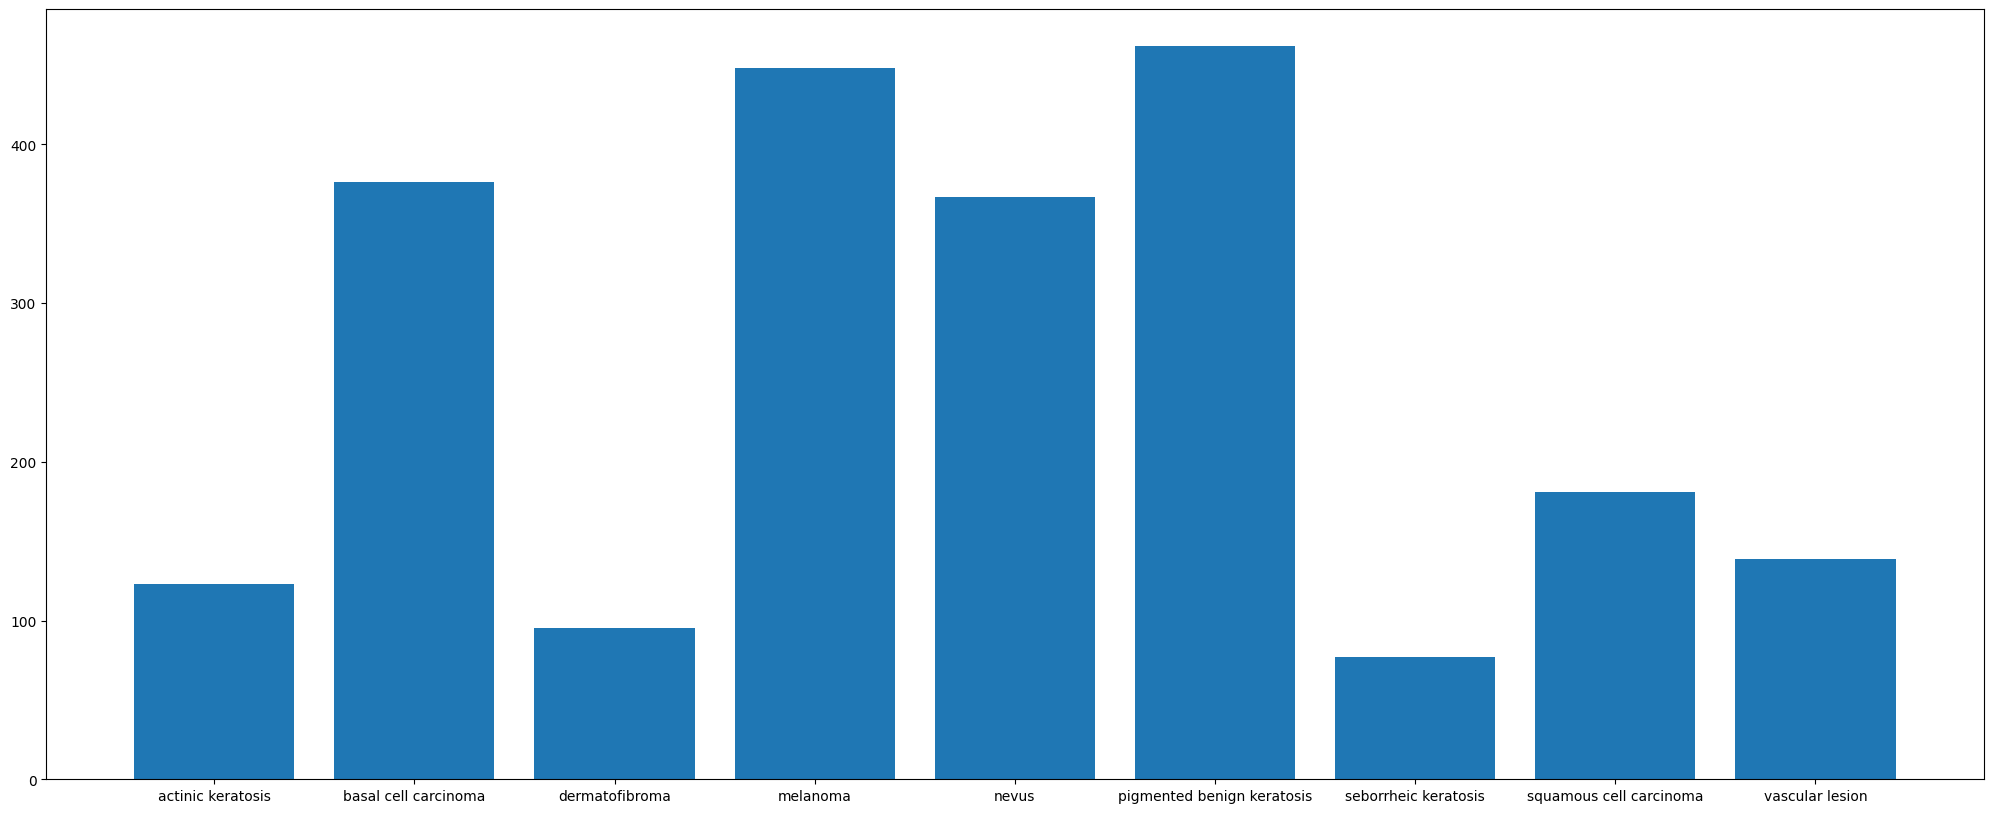

In [45]:
# Visualize class imbalance through chart
count=[]
for i in Name_of_class:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(Name_of_class,count)

**'seborrheic keratosis'** is having the least no of images i,e 77

**'pigmented benign keratosis'** is having the maximum no of images i,e 462

In [46]:
# lebel checking
path_list=[]
lesion_list=[]
for i in Name_of_class:
      for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/Train/actinic keratosis...,actinic keratosis
1,/content/drive/MyDrive/Train/actinic keratosis...,actinic keratosis
2,/content/drive/MyDrive/Train/actinic keratosis...,actinic keratosis
3,/content/drive/MyDrive/Train/actinic keratosis...,actinic keratosis
4,/content/drive/MyDrive/Train/actinic keratosis...,actinic keratosis
...,...,...
2263,/content/drive/MyDrive/Train/vascular lesion/I...,vascular lesion
2264,/content/drive/MyDrive/Train/vascular lesion/I...,vascular lesion
2265,/content/drive/MyDrive/Train/vascular lesion/I...,vascular lesion
2266,/content/drive/MyDrive/Train/vascular lesion/I...,vascular lesion


**Augmentor Package**

A python package known as Augmentor is utilized to add more examples across all classes with the goal that none of the classes have not many examples.

Procedure to use Agumentor:

1. Start pipeline to folder of sample image
2. Mention nos of operation to be done on pipline object.
3. Call the method

In [47]:
import Augmentor
for i in Name_of_class:
  augmnt_pipeline = Augmentor.Pipeline(str(data_dir_train) + '/'+ i)
  augmnt_pipeline.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  augmnt_pipeline.sample(500)

Initialised with 123 image(s) found.
Output directory set to /content/drive/MyDrive/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7CC33B9C3A90>: 100%|██████████| 500/500 [00:18<00:00, 27.48 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CC3207078E0>: 100%|██████████| 500/500 [00:19<00:00, 25.20 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CC4275C3190>: 100%|██████████| 500/500 [00:17<00:00, 27.79 Samples/s]


Initialised with 448 image(s) found.
Output directory set to /content/drive/MyDrive/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3872x2592 at 0x7CC33B9DF9A0>: 100%|██████████| 500/500 [01:29<00:00,  5.56 Samples/s]


Initialised with 367 image(s) found.
Output directory set to /content/drive/MyDrive/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=576x768 at 0x7CC32077BC10>: 100%|██████████| 500/500 [01:19<00:00,  6.29 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CC3984FB400>: 100%|██████████| 500/500 [00:18<00:00, 26.51 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7CC38050B460>: 100%|██████████| 500/500 [00:41<00:00, 12.14 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CC32076F550>: 100%|██████████| 500/500 [00:19<00:00, 26.28 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CC3984FAE60>: 100%|██████████| 500/500 [00:21<00:00, 23.67 Samples/s]


Augmentor has stored agumented images in the new subfolder output folder of each class folder. Lets have count for total.

In [49]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


**Checking distribution of augmented data after adding new images to the original training data.**

In [50]:
import os
import glob
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [51]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [52]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [55]:
# Assuming dataframe_dict_new is a dictionary and original_df is an existing DataFrame
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=['Path', 'Label'])

# Combine the DataFrames
new_df = pd.concat([original_df, df2], ignore_index=True)

In [56]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      948
basal cell carcinoma          876
nevus                         867
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             623
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

Now we have added 500 images to all the classes to maintain some class balance.

In [57]:
batch_size = 32
img_height = 180
img_width = 180

**Splitting Training dataset**

In [58]:
augmented_data_dir = data_dir_train
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  augmented_data_dir,
  seed=123,
  validation_split = 0.2,
  subset ='training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6768 files belonging to 9 classes.
Using 5415 files for training.


**segmenting train and validation set from dataset**

In [59]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  augmented_data_dir,
  seed=123,
  validation_split = 0.2,
  subset ='validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6768 files belonging to 9 classes.
Using 1353 files for validation.


### Building Model 3 After additional 500 images in output folder

In [60]:
# Include BatchNormalization, Dropout
Normalised_Model=Sequential()

Normalised_Model.add(InputLayer((180,180,3)))
Normalised_Model.add(Rescaling(1./255))

Normalised_Model.add(Conv2D(32, (3, 3), padding='same'))
Normalised_Model.add(BatchNormalization())
Normalised_Model.add(Activation('relu'))

Normalised_Model.add(MaxPooling2D(pool_size=(2, 2)))

Normalised_Model.add(Conv2D(32, (3, 3), padding='same'))
Normalised_Model.add(BatchNormalization())
Normalised_Model.add(Activation('relu'))

Normalised_Model.add(MaxPooling2D(pool_size=(2, 2)))

Normalised_Model.add(Conv2D(32, (3, 3), padding='same'))
Normalised_Model.add(BatchNormalization())
Normalised_Model.add(Activation('relu'))

Normalised_Model.add(MaxPooling2D(pool_size=(2, 2)))

Normalised_Model.add(Conv2D(64, (3, 3)))
Normalised_Model.add(BatchNormalization())
Normalised_Model.add(Activation('relu'))

Normalised_Model.add(MaxPooling2D(pool_size=(2, 2)))

Normalised_Model.add(Flatten())
Normalised_Model.add(Dense(512, activation='relu'))
Normalised_Model.add(Dense(256, activation='relu'))
Normalised_Model.add(Dropout(0.25))

Normalised_Model.add(Dense(9, activation='softmax'))


# having glance on layer summery
Normalised_Model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 90, 90, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 45, 45, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 45, 45, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 22, 22, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 20, 20, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 20, 20, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       3,277,312 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,449,481 (13.16 MB)

 Trainable params: 3,449,161 (13.16 MB)

 Non-trainable params: 320 (1.25 KB)

### Compiling the 3rd model built after after adding 500 additinal images with adam optimiser

In [61]:
Normalised_Model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

### Training the 3rd model built after after adding 500 additinal images with 50 epoches

In [62]:
epochs = 30
history = Normalised_Model.fit(
  train_dataset,
  validation_data=validation_dataset ,
  epochs=epochs,
)


Epoch 1/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 57s 276ms/step - accuracy: 0.2777 - loss: 2.8577 - val_accuracy: 0.1234 - val_loss: 2.6164
Epoch 2/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 40s 238ms/step - accuracy: 0.4725 - loss: 1.4255 - val_accuracy: 0.2668 - val_loss: 1.9553
Epoch 3/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 41s 236ms/step - accuracy: 0.5304 - loss: 1.2401 - val_accuracy: 0.5528 - val_loss: 1.1542
Epoch 4/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 43s 246ms/step - accuracy: 0.6121 - loss: 1.0397 - val_accuracy: 0.5115 - val_loss: 1.4020
Epoch 5/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 80s 232ms/step - accuracy: 0.6709 - loss: 0.9069 - val_accuracy: 0.5994 - val_loss: 1.2593
Epoch 6/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 43s 247ms/step - accuracy: 0.7405 - loss: 0.6999 - val_accuracy: 0.5218 - val_loss: 1.5952
Epoch 7/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 42s 245ms/step - accuracy: 0.7366 - loss: 0.7041 - val_accuracy: 0.5418 - val_loss: 1.4841
Epoch 8/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 80s 235ms/step - accuracy: 0.8093 - loss: 0

**Visualizing the result**

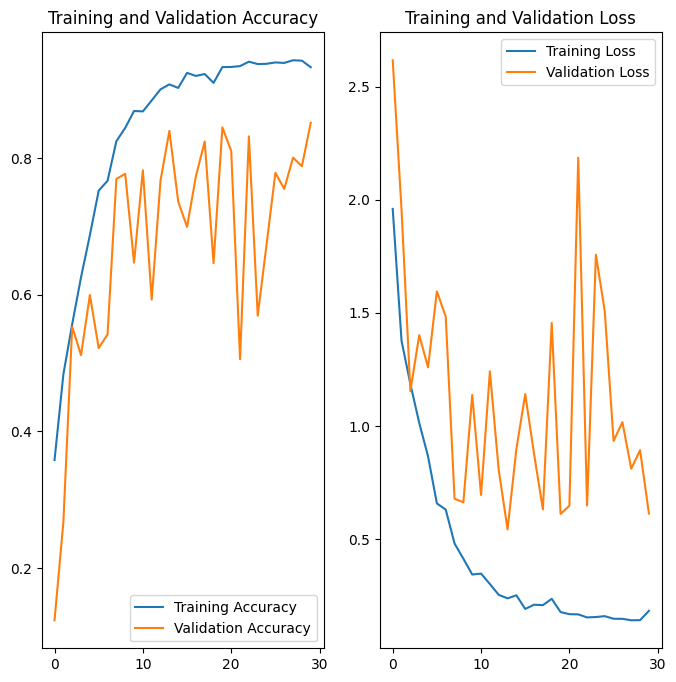

In [63]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings:**

Train Data Accuracy : 0.9329

Train Loss : 0.1665

Validation Data Accuracy : 0.7929

Validation Loss - 0.8101

**Nutshell:**

we can see that this model's validation accuracy is higher than earlier models. This model, however, is also overfitting.

Class rebalancing, droupout, and batch normalisation help achieve better results than a simple model.


**Correction:**

The Model can be further improved by tuning the hyperparameter.


## Conclusion:

We observe gradual improvement from Model 1 to Model 3:

**Model 1:** Simple CNN Model

Accuracy: 0.9244 | Validation accuracy : 0.5391

**Model 2:** Augmented data with droupout

Accuracy: 0.5965 | Validation accuracy : 0.5369

**Model 3:** Class rebalance,BatchNormalization with Dropout

Accuracy: 0.9329 | Validation accuracy : 0.7929

With the right hyper-parameter tuning, accuracy can be improved even more. We can experiment with different CNN configurations, loss functions, optimizers, and layer counts to see accuracy pattern.